# Description

This notebook will allow the user to perform a quick normalization:
    - by selecting 1 or a set of Open Beam (OBs) files
    or
    - by using the first file loaded
    
Quick profile plot will also be available

# Python Import

In [1]:
try:
    from PyQt4.QtGui import QFileDialog
    from PyQt4 import QtCore, QtGui
except ImportError:
    from PyQt5.QtWidgets import QFileDialog
    from PyQt5 import QtCore, QtGui
    
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import sys
import glob
import os

from plotly.offline import plot, init_notebook_mode, iplot
init_notebook_mode()
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from ipywidgets.widgets import interact
from ipywidgets import widgets
from IPython.display import display
from ipywidgets import widgets

import config_handler
import gui_widgets
import file_handler

!jupyter nbextension enable --py --sys-prefix widgetsnbextension

Unrecognized JSON config file version, assuming version 1
Unrecognized JSON config file version, assuming version 1
Collisions detected in jupyter_notebook_config.py and jupyter_notebook_config.json config files. jupyter_notebook_config.json has higher priority: {
      "NotebookApp": {
        "nbserver_extensions": "{'nb_anacondacloud': True, 'nbpresent': True, 'nb_conda': True} ignored, using {'jupyter_nbextensions_configurator': True}"
      }
    }
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
%gui qt

# Normalization

## Select Normalization Type

In [3]:
list_algo = ['OB', 'First Image Loaded']
algo = widgets.Dropdown(options=list_algo,
                       description='Select Normalization Type')
algo

In [4]:
default_folder = config_handler.load_config(key = 'default_folder')
if sys.platform == 'linux':
        if default_folder == '':
            default_folder = '/HFIR/CG1DImaging/IPTS_17981/'
else:
    default_folder = '.'

if algo.value == 'OB':
    default_ob_folder = config_handler.load_config(key = 'ob_folder')
    if default_ob_folder == '':
        default_ob_folder = default_folder
    ob_files = gui_widgets.gui_tiff(dir = default_ob_folder,
                                   message = 'Select OB Files ...')

    if sys.platform == 'linux':
        ob_files = ob_files[0]  
        
    if not ob_files == []:
        path = os.path.dirname(ob_files[0])
        config_handler.save_config(key='ob_folder', value=path)

        #import images
        w = widgets.IntProgress()
        w.max = len(ob_files)
        display(w)
        
        mean_ob = []
        for _index, _ob_file in enumerate(ob_files):
            _ob_data = file_handler.load_data(_ob_file)
            mean_ob.append(_ob_data)
            w.value = _index + 1

        normalization_data = np.mean(mean_ob, axis=0)

## Select and Load Data Files

In [7]:
default_data_folder = config_handler.load_config(key = 'data_folder')
if default_data_folder == '':
    default_data_folder = default_folder
data_folder = gui_widgets.gui_dname(dir = default_data_folder,
                                   message = 'Select Data Folder ...')

list_data = glob.glob(data_folder + '/*.tif*')
if not list_data == []:
    path = os.path.dirname(list_data[0])
    config_handler.save_config(key='data_folder', value=path)

    #import images
    w = widgets.IntProgress()
    w.max = len(list_data)
    display(w)

    data =[]
    for _index, _file in enumerate(list_data):
        _image = file_handler.load_data(_file)
        data.append(_image)
        w.value = _index+1
        
if algo.value == 'First Image Loaded':
    normalization_data = data[0]

## Perform Normalization and Display Data

### Normalization

In [8]:
 #import images
w = widgets.IntProgress()
w.max = len(list_data)
display(w)

normalized_data = []
for _index, _data in enumerate(data):
    _norm = _data / normalization_data
    normalized_data.append(_norm)
    
    w.value = _index + 1

### Display Data and Select Intensity Range

[0.0, 0.9]

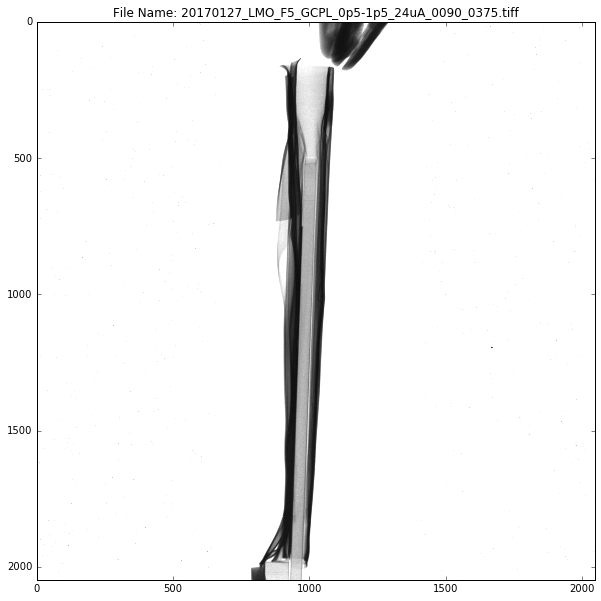

In [9]:
min_counts = config_handler.load_config(key='norm_min_counts')
if min_counts == '':
    min_counts = 0

max_counts = config_handler.load_config(key='norm_max_counts')
if max_counts == '':
    max_counts = 10

def plot_images(file_index, min_counts, max_counts):
    
    fig = plt.figure(figsize=(10,10))
    ax_img = plt.subplot(111)
    ax_img.imshow(normalized_data[file_index],
                 cmap='gray',
                 vmin=min_counts,
                 vmax=max_counts)
    ax_img.set_title("File Name: {}".format(os.path.basename(list_data[file_index])))
    
    return [min_counts, max_counts]
    
preview = interact(plot_images,
                  file_index = widgets.IntSlider(min=0,
                                                max=len(list_data)-1,
                                                step=1,
                                                value=0,
                                                description="File Index"),
                  min_counts = widgets.FloatSlider(min=0,
                                                max=10,
                                                value=min_counts),
                  max_counts = widgets.FloatSlider(min=0,
                                                 max=10,
                                                 value=max_counts),
                                                 )

### Select Zoom Data

[900, 1100, 500, 1000]

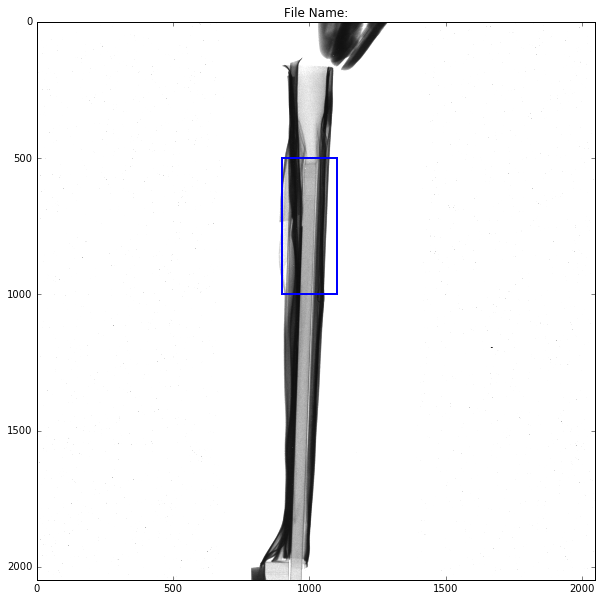

In [10]:
[height, width] = np.shape(normalized_data[0])

[min_counts, max_counts] = preview.widget.result
config_handler.save_config(key='norm_min_counts', value=min_counts)
config_handler.save_config(key='norm_max_counts', value=max_counts)

left = config_handler.load_config(key='norm_zoom_left')
if left == '':
    left = 1
right = config_handler.load_config(key='norm_zoom_right')
if right == '':
    right = width

top = config_handler.load_config(key='norm_zoom_top')
if top == '':
    top = 0

bottom = config_handler.load_config(key='norm_zoom_bottom')
if bottom == '':
    bottom = height

def plot_images(file_index, left, right, top, bottom):
    
    _norm = normalized_data[file_index]
    
    fig = plt.figure(figsize=(10,10))
    ax_img = plt.subplot(111)
    ax_img.imshow(_norm,
                 cmap='gray',
                 vmin=min_counts,
                 vmax=max_counts)
    ax_img.set_title("File Name:".format(list_data[file_index]))
    
    _rectangle = patches.Rectangle((left, top),
                                  right-left,
                                  bottom-top,
                                  edgecolor = 'blue',
                                  linewidth = 2,
                                  fill = False)
    ax_img.add_patch(_rectangle)
    
    return [left, right, top, bottom]
    
zoom = interact(plot_images,
                  file_index = widgets.IntSlider(min=0,
                                                max=len(list_data)-1,
                                                step=1,
                                                value=0,
                                                description="File Index"),
                  left = widgets.IntSlider(min=0,
                                            max=width,
                                            step=1,
                                            value=left,
                                            description='Left'),
                  right = widgets.IntSlider(min=0,
                                           max=width,
                                           value=right,
                                           step=1,
                                           description='Right'),
                  top = widgets.IntSlider(min=0,
                                            max=height,
                                            step=1,
                                            value=top,
                                            description='Top'),
                   bottom = widgets.IntSlider(min=0,
                                            max=height,
                                            step=1,
                                            value=bottom,
                                            description='Bottom'))

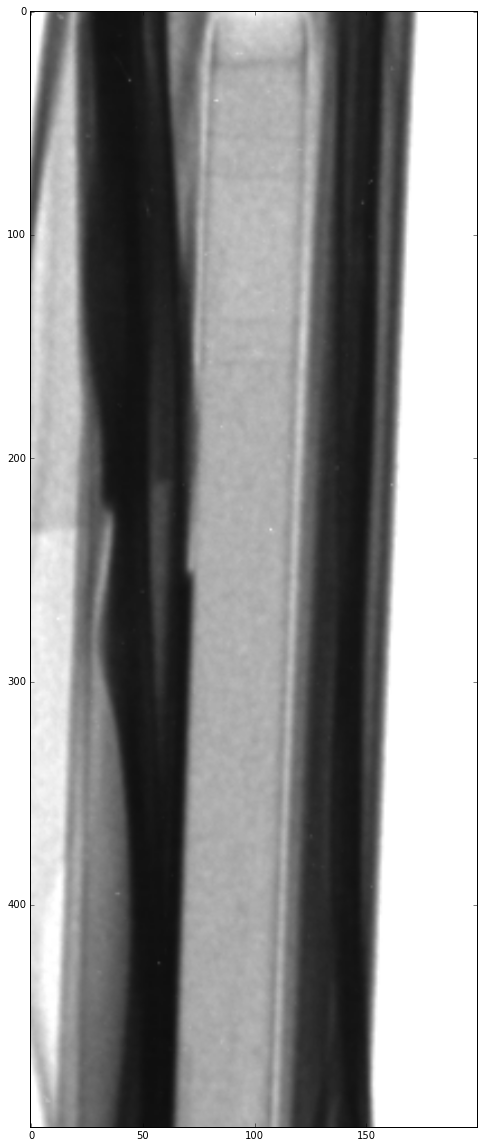

In [11]:
[left_zoom, right_zoom, top_zoom, bottom_zoom] = zoom.widget.result

config_handler.save_config(key='norm_zoom_left', value=str(left_zoom))
config_handler.save_config(key='norm_zoom_right', value=str(right_zoom))
config_handler.save_config(key='norm_zoom_top', value=str(top_zoom))
config_handler.save_config(key='norm_zoom_bottom', value=str(bottom_zoom))

def plot_images(file_index):
    
    _norm = normalized_data[file_index]
    
    fig = plt.figure(figsize=(20,20))

    ax_img = plt.subplot(111)
    ax_img.imshow(_norm[top_zoom:bottom_zoom,left_zoom:right_zoom],
                 cmap='gray',
                 vmin=min_counts,
                 vmax=max_counts)
    
crop = interact(plot_images,
                  file_index = widgets.IntSlider(min=0,
                                                max=len(list_data)-1,
                                                step=1,
                                                value=0,
                                                description="File Index"))

# Profile 

## Select Profile

- Direction
- Region

In [12]:
left_roi = config_handler.load_config(key='norm_roi_left')
if left_roi == '':
    left_roi = left_zoom
else:
    left_roi = np.int(left_roi)
    
right_roi = config_handler.load_config(key='norm_roi_right')
if right_roi == '':
    right_roi = right_zoom
else:
    right_roi = np.int(right_roi)

top_roi = config_handler.load_config(key='norm_roi_top')
if top_roi == '':
    top_roi = top_zoom
else:
    top_roi = np.int(top_roi)

bottom_roi = config_handler.load_config(key='norm_roi_bottom')
if bottom_roi == '':
    bottom_roi = bottom_zoom
else:
    bottom_roi = np.int(bottom_roi)

[900, 1100, 500, 1000, 'h']

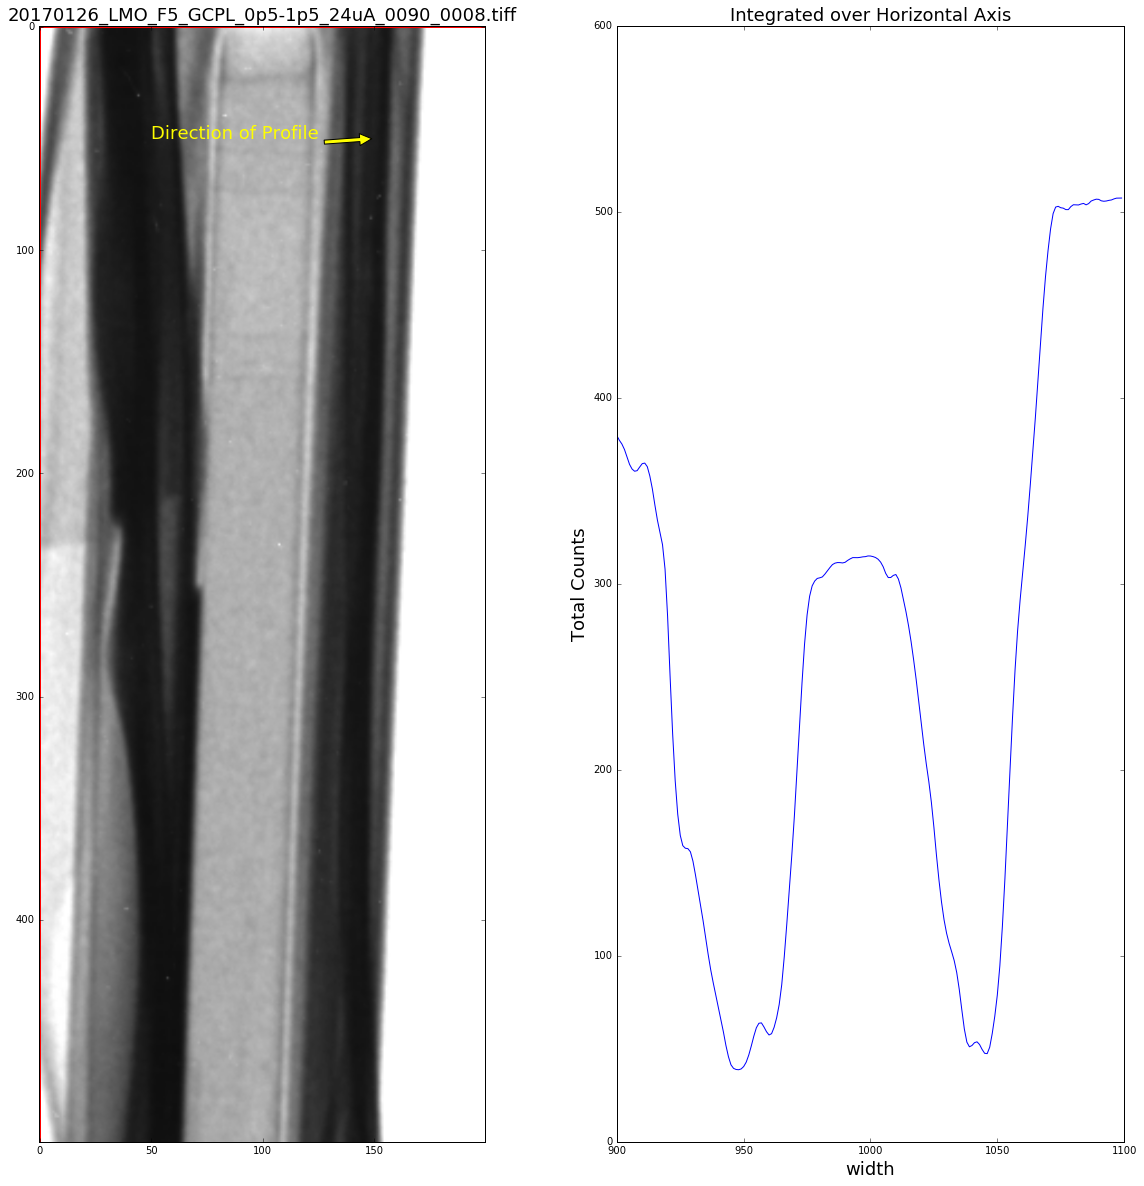

In [19]:
def plot_images(file_index, left, right, top, bottom, integration_direction):
    
    _norm = normalized_data[file_index]
    _zoom_norm = _norm[top_zoom:bottom_zoom, left_zoom:right_zoom]
    
    fig = plt.figure(figsize=(20,20))
    ax_img = plt.subplot(121)
    ax_img.imshow(_zoom_norm,
                 cmap='gray',
                 vmin=min_counts,
                 vmax=max_counts)
    ax_img.set_title("{}".format(os.path.basename(list_data[file_index])), fontsize=18)
    
    _left = np.min([left, right])
    _right = np.max([left, right])
    _top = np.min([top, bottom])
    _bottom = np.max([top, bottom])
    
    _live_left = _left - left_zoom
    _live_right = _right - left_zoom
    _live_top = _top - top_zoom
    _live_bottom = _bottom - top_zoom
    
    _rectangle = patches.Rectangle((_live_left, _live_top),
                                  _live_right - _live_left,
                                  _live_bottom - _live_top,
                                  edgecolor = 'red',
                                  linewidth = 2,
                                  fill = False)
    ax_img.add_patch(_rectangle)

    [img_height, img_width] = np.shape(_zoom_norm)
    
    if integration_direction == 'h':
        ax_img.annotate('Direction of Profile', color='yellow',
                        fontsize=18,
                        xy=[img_width-50, 50],
                    xytext = [50, 50],
                    arrowprops=dict(facecolor='yellow', shrink=0.05)) 
    else:
         ax_img.annotate('Direction\n of \nProfile', xy=[img_width-50, img_height-50],
                         color='yellow', fontsize=18,
                         horizontalalignment='right',
                    xytext = [img_width-50, 200],
                    arrowprops=dict(facecolor='yellow', shrink=0.05)) 
    
    # profile plot
    ax_inte = plt.subplot(122)
    _integration = _zoom_norm[top-top_zoom:bottom-top_zoom, left-left_zoom:right-left_zoom]

    [profile_height, profile_width] = np.shape(_integration)
    if integration_direction == 'h':
        _xaxis = np.arange(profile_width) + left
        _inte = np.sum(_integration, axis=0)
        _title = "Integrated over Horizontal Axis"
        _xlabel = 'width'
    else:
        _xaxis = np.arange(profile_height) + top
        _inte = np.sum(_integration, axis=1)
        _title = "Integrated over Vertical Axis"
        _xlabel = 'height'
    
    _ylabel = 'Total Counts'
    
    ax_inte.plot(_xaxis,_inte)
    ax_inte.set_title(_title, fontsize=18)
    ax_inte.set_xlabel(_xlabel, fontsize=18)
    ax_inte.set_ylabel(_ylabel, fontsize=18)
    
    return [left, right, top, bottom, integration_direction]
      
profile = interact(plot_images,
                  file_index = widgets.IntSlider(min=0,
                                                max=len(list_data)-1,
                                                step=1,
                                                value=0,
                                                description="File Index"),
                  left = widgets.IntSlider(min=left_zoom,
                                            max=right_zoom,
                                            step=1,
                                            value=left_zoom,
                                            description='Left ROI'),
                  right = widgets.IntSlider(min=left_zoom,
                                           max=right_zoom,
                                           value=right_zoom,
                                           step=1,
                                           description='Right ROI'),
                  top = widgets.IntSlider(min=top_zoom,
                                            max=bottom_zoom,
                                            step=1,
                                            value=top_zoom,
                                            description='Top ROI'),
                   bottom = widgets.IntSlider(min=top_zoom,
                                            max=bottom_zoom,
                                            step=1,
                                            value=bottom_zoom,
                                            description='Bottom ROI'),
               integration_direction = widgets.RadioButtons(options={'horizontal': 'h','vertical':'v'},
                                                           description = 'Profile Type',
                                                           value='h'))

# Profile over all Images


In [21]:
[left_profile, right_profile, top_profile, bottom_profile, integration_direction] = profile.widget.result

config_handler.save_config(key='norm_roi_left', value=left_profile)
config_handler.save_config(key='norm_roi_right', value=right_profile)
config_handler.save_config(key='norm_roi_top', value=top_profile)
config_handler.save_config(key='norm_roi_bottom', value=bottom_profile)
config_handler.save_config(key='integration_direction', value=integration_direction)

In [25]:
_trace = []

for _index, _norm in enumerate(normalized_data):
    _zoom_norm = _norm[top_profile:bottom_profile, left_profile:right_profile]
    if integration_direction == 'h':
        _inte_zoom_norm = np.sum(_zoom_norm, axis=0)
        if _index == 0:
            [profile_height, profile_width] = np.shape(_zoom_norm)
            _xaxis = np.arange(profile_width) + left_profile    
    else:
        _inte_zoom_norm = np.sum(_zoom_norm, axis=1)
        if _index == 0:
            [profile_height, profile_width] = np.shape(_zoom_norm)
            _xaxis = np.arange(profile_height) + top_profile    

    _local_trace = go.Scatter(x=_xaxis,
                             y=_inte_zoom_norm,
                             name='File Index {}'.format(_index),
                             mode='markers')
    _trace.append(_local_trace)
    
figure = go.Figure(data=_trace)
iplot(figure)

            

# Export Normalized Files

In [22]:
output_folder = config_handler.load_config(key='output_folder')
output_folder = gui_widgets.gui_dname(dir=output_folder,
                                message='Select The Output Folder ...')
if not output_folder == '':
    config_handler.save_config(key='output_folder', value=output_folder)

 #import images
w = widgets.IntProgress()
w.max = len(list_data)
display(w)

for _index, _norm in enumerate(normalized_data):
    _name = os.path.basename(list_data[_index])
    _new_name = os.path.join(output_folder, _name)
    file_handler.save_tiff(file_name=_new_name, data=_norm)
    
    w.value = _index + 1    